In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split

import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Normal
from torch.distributions import kl

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The model will be trained on {device}.")
EPS = 1e-6  # for numerical stability control

The model will be trained on cpu.


## Conventional NNs

We will perform a classification task on the "two moons" dataset.

A standard fully-connected NN is used first, and then we proceed with a Bayesian NN with the same struture for comparision.



#### Load dataset

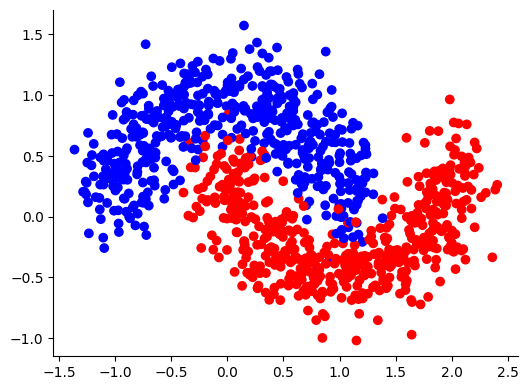

In [2]:
# Generate the moons dataset
X, Y = datasets.make_moons(1000, noise=0.20, random_state=6)

# Plot the dataset
plt.figure(figsize=(6, 4.5))
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="bwr")
sns.despine()
plt.show()

In [3]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=45)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.get_default_dtype())
X_test = torch.tensor(X_test, dtype=torch.get_default_dtype())
y_train = torch.tensor(y_train, dtype=torch.get_default_dtype()).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.get_default_dtype()).view(-1, 1)

# Set the meshgrid
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 2
y_min, y_max = X[:, 1].min() - 2, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#### construct a conventional NN

In [4]:
class ConventionalNN(nn.Module):
    def __init__(self, features):
        super(ConventionalNN, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(features) - 1):
            self.layers.append(nn.Linear(features[i], features[i+1]))
            if i != len(features) - 2:
                self.layers.append(nn.ReLU())
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        return self.sigmoid(X)

    def loss_fn(self, X, y, reg_lambda=0., reg_ord=2):
        y_pred = self.forward(X)
        loss = F.binary_cross_entropy(y_pred, y)
        if reg_lambda == 0.:
            return loss
        else:  # We can add a regularizer here to penalize large weights.
            reg_term = sum(torch.linalg.vector_norm(param, ord=reg_ord) ** reg_ord for param in self.parameters())
            return loss + reg_lambda / y.shape[0] * reg_term

    @torch.no_grad()
    def predict(self, X_test, y_test=None, batch_size=None, device=torch.device('cpu')):
        test_dataset = TensorDataset(X_test, y_test) if y_test is not None else TensorDataset(X_test)
        batch_size = len(test_dataset) if batch_size is None else batch_size
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        self.to(device)
        if y_test is not None:
            wrong = 0
            for x, y in test_dataloader:
                x, y = x.to(device), y.to(device)
                y_pred = self.forward(x)
                y_pred = (y_pred >= 0.5).to(torch.get_default_dtype())
                wrong += (y_pred - y).abs().sum().item()
            return 1 - wrong / len(test_dataset)
        else:
            preds = []
            for x in test_dataloader:
                y_pred = self.forward(x[0].to(device))
                preds.append(y_pred)
            return torch.cat(preds, dim=-2).to(torch.device('cpu'))

# construct NN
features = [2, 8, 16, 16, 8, 1]

mlp = ConventionalNN(features)
mlp

#### Train NN
+ train the NN without the regularization. This training corresponds to a Maximum Likelihood Estimation (MLE) of the parameters.

Epoch [50/1000], Loss: 0.2665
Epoch [100/1000], Loss: 0.0958
Epoch [150/1000], Loss: 0.0641
Epoch [200/1000], Loss: 0.0585
Epoch [250/1000], Loss: 0.0546
Epoch [300/1000], Loss: 0.0526
Epoch [350/1000], Loss: 0.0509
Epoch [400/1000], Loss: 0.0510
Epoch [450/1000], Loss: 0.0508
Epoch [500/1000], Loss: 0.0497
Epoch [550/1000], Loss: 0.0495
Epoch [600/1000], Loss: 0.0493
Epoch [650/1000], Loss: 0.0501
Epoch [700/1000], Loss: 0.0490
Epoch [750/1000], Loss: 0.0486
Epoch [800/1000], Loss: 0.0483
Epoch [850/1000], Loss: 0.0486
Epoch [900/1000], Loss: 0.0480
Epoch [950/1000], Loss: 0.0484
Epoch [1000/1000], Loss: 0.0490


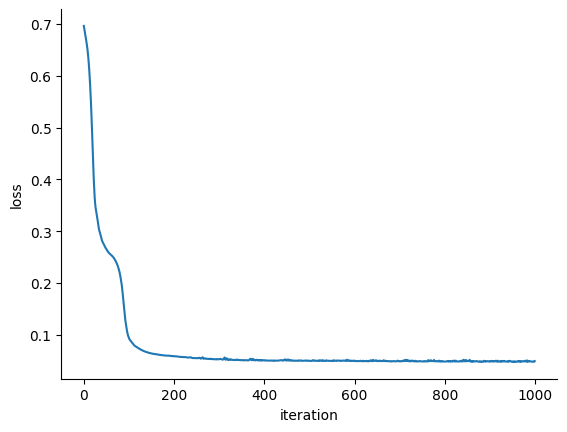

In [5]:
def train(
        model, X, y, batch_size=32, lr=0.01, reg_lambda=0., reg_ord=2,
        epochs=10, print_iters=50, device=torch.device('cpu')
):
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # DataLoader for batching
    dataset = TensorDataset(X, y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()  # Set model to training mode
    model.to(device)

    losses = []
    for epoch in range(epochs):
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()                 # Zero the gradient
            loss = model.loss_fn(
                inputs, labels, reg_lambda, reg_ord
            )                                     # Loss function (CrossEntropyLoss in this case)
            loss.backward()                       # Backpropagation
            optimizer.step()                      # Update weights
            losses.append(loss.item())

        if (epoch + 1) % print_iters == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return model, losses

mlp, loss_list = train(mlp, X_train, y_train, batch_size=500, lr=0.01, epochs=1000, device=device)

plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
sns.despine()

+ prediction on the test data

In [6]:
mlp.eval()
acc = mlp.predict(X_test, y_test, device=device)

print(f"The accuracy on the test data is {acc * 100:.2f}%")

The accuracy on the test data is 96.40%


+ plot the decision boundary

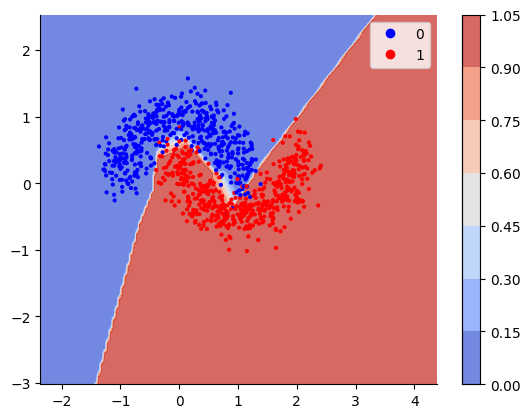

In [7]:
def plot_binary_class(X_scatters, y_scatters, xx1_grid, xx2_grid, grid_preds_mean, legend=False, color_bar=False):
    """
    Function to plot binary classification outputs.
    """
    fig, ax = plt.subplots(1, 1)

    CS = ax.contourf(xx1_grid, xx2_grid, grid_preds_mean, cmap="coolwarm", alpha=0.8)
    hs = ax.scatter(X_scatters[:, 0], X_scatters[:, 1], c=y_scatters, s=4, cmap="bwr")

    if legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_actual, labels_actual = hs.legend_elements()
        handles_actual.extend(handles)
        labels_actual.extend(labels)
        ax.legend(handles_actual, labels_actual)

    if color_bar:
        fig.colorbar(CS)

    sns.despine()


# Predict on grid
inputs = np.stack([xx.ravel(), yy.ravel()], axis=-1)
p = mlp.predict(torch.as_tensor(inputs, dtype=torch.get_default_dtype()), device=device)
p = p.reshape(xx.shape)

plot_binary_class(X, Y, xx, yy, p, legend=True, color_bar=True)

+ train the NN with a L2 regularizer. In such case it returns a Maximum A Posterior (MAP) estimation of the parameters. You can also try other types of regularizers like L2.

Epoch [50/1000], Loss: 0.2247
Epoch [100/1000], Loss: 0.0792
Epoch [150/1000], Loss: 0.0716
Epoch [200/1000], Loss: 0.0693
Epoch [250/1000], Loss: 0.0680
Epoch [300/1000], Loss: 0.0669
Epoch [350/1000], Loss: 0.0661
Epoch [400/1000], Loss: 0.0666
Epoch [450/1000], Loss: 0.0649
Epoch [500/1000], Loss: 0.0644
Epoch [550/1000], Loss: 0.0642
Epoch [600/1000], Loss: 0.0636
Epoch [650/1000], Loss: 0.0649
Epoch [700/1000], Loss: 0.0631
Epoch [750/1000], Loss: 0.0638
Epoch [800/1000], Loss: 0.0631
Epoch [850/1000], Loss: 0.0629
Epoch [900/1000], Loss: 0.0625
Epoch [950/1000], Loss: 0.0629
Epoch [1000/1000], Loss: 0.0626


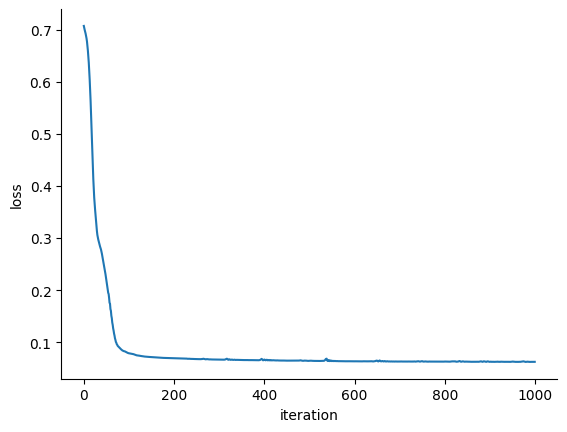

In [11]:
mlp_map = ConventionalNN(features)

mlp_map, loss_list = train(mlp_map, X_train, y_train, reg_lambda=0.1, reg_ord=2,
                           lr=0.01, batch_size=500, epochs=1000, device=device)

plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
sns.despine()

The accuracy on the test data is 97.00%


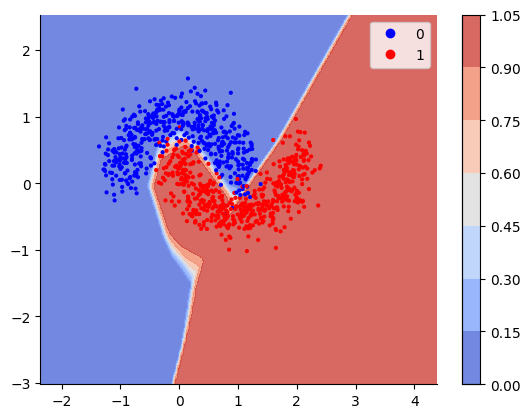

In [12]:
# Predict on test data
mlp_map.eval()
acc = mlp_map.predict(X_test, y_test, device=device)

print(f"The accuracy on the test data is {acc * 100:.2f}%")

# Predict on grid
p = mlp_map.predict(torch.as_tensor(inputs, dtype=torch.get_default_dtype()), device=device)
p = p.reshape(xx.shape)

plot_binary_class(X, Y, xx, yy, p, legend=True, color_bar=True)

## Bayesian NNs - Prior over Weights

A BNN is a NN that uses (approximate) Bayesian inference for uncertainty esitmation. We can treat the NN parameters as random variables and infer them using Bayesian posterior inference.

To begin with, we will construct a BNN layer with Gaussian priors over the weights, and then we will define a BNN.

#### construct a Bayesian linear layer




In [13]:
class BayesianLinear(nn.Module):
    def __init__(
            self, in_features, out_features,
            prior_weight_std=0.1, prior_bias_std=0.1, lecun_init=False
    ):
        super(BayesianLinear, self).__init__()

        # Define the prior params
        prior_mean = 0.
        if lecun_init:  # LeCun initialization：prior variance scales as 1/dim_in
            prior_weight_std /= in_features ** 0.5
            prior_bias_std /= in_features ** 0.5
        # Prior parameters registered as constants
        self.register_buffer('prior_weight_mean', torch.full([out_features, in_features], prior_mean))
        self.register_buffer('prior_weight_std', torch.full([out_features, in_features], prior_weight_std))
        self.register_buffer('prior_bias_mean', torch.full([out_features], prior_mean))
        self.register_buffer('prior_bias_std', torch.full([out_features], prior_bias_std))

    def prior_forward(self, x):
        # Sample weights and biases from prior normal distributions
        prior_weight = self.prior_weight_mean + self.prior_weight_std * torch.randn_like(self.prior_weight_std)
        prior_bias = self.prior_bias_mean + self.prior_bias_std * torch.randn_like(self.prior_bias_std)
        return F.linear(x, prior_weight, prior_bias)


In [14]:
class BayesianNN(nn.Module):
    def __init__(self, features, **layer_prior_kwargs):
        super(BayesianNN, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(features) - 1):
            self.layers.append(BayesianLinear(features[i], features[i+1], **layer_prior_kwargs))
            if i != len(features) - 2:
                self.layers.append(nn.ReLU())
        self.sigmoid = nn.Sigmoid()

    @torch.no_grad()
    def prior_forward(self, x):
        for layer in self.layers:
            if isinstance(layer, BayesianLinear):
                x = layer.prior_forward(x)
            else:
                x = layer(x)
        return self.sigmoid(x)

#### Random functions from the prior

+ We then sample the prior random functions output by the BNN to see the effects of changing the prior hyperparameters.

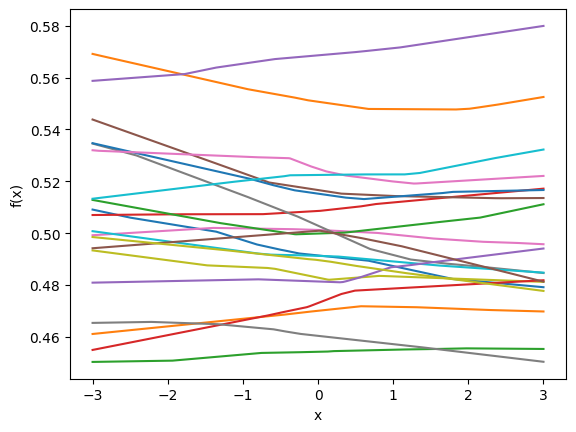

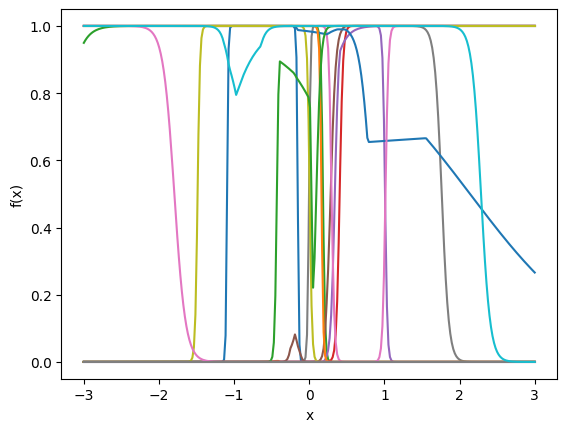

In [15]:
def sample_prior(model, num_samples, x):
    # Sample random functions
    prior_samples = []
    for _ in range(num_samples):
        sample = model.prior_forward(x)
        prior_samples.append(sample)

    # Plot samples
    for i in range(num_samples):
        plt.plot(x.numpy().reshape([-1]), prior_samples[i].numpy().reshape([-1]))

    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.show()


# Construct a 2-layer BNN
features = [1, 10, 1]
BNN = BayesianNN(features)

# Plot
num_samples = 20
x = torch.linspace(-3, 3, 300).view(-1, 1)
sample_prior(BNN, num_samples, x)

# We can change the prior to see its effct on the output functions
BNN = BayesianNN(features, prior_weight_std=10., prior_bias_std=5., lecun_init=True)
sample_prior(BNN, num_samples, x)

## Inference - Posterior Approximation
This part will employ mean-field variational inference (MFVI, also known as [Bayes-by-backprop](https://arxiv.org/abs/1505.05424)) to approximate the posterior distributions of the parameters of the BNN.

### Mean-field Variational Inference (MFVI)

#### Bayesian linear layers with variational distributions

In [17]:
class MFVIBayesianLinear(BayesianLinear):  # inherit
    def __init__(
            self, in_features, out_features,
            init_std=0.1, **layer_prior_kwargs
    ):
        super(MFVIBayesianLinear, self).__init__(in_features, out_features, **layer_prior_kwargs)

        # Mean and log variance for weights and biases of variational distributions
        self.weight_mean = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_logstd = nn.Parameter(torch.ones(out_features, in_features))
        self.bias_mean = nn.Parameter(torch.zeros(out_features))
        self.bias_logstd = nn.Parameter(torch.ones(out_features))

        # initialization
        self.reset_params(in_features, init_std)

    def reset_params(self, in_features, init_std):
        # initialization
        nn.init.kaiming_uniform_(self.weight_mean)
        bound = 1 / in_features ** 0.5
        nn.init.uniform_(self.bias_mean, -bound, bound)
        nn.init.constant_(self.weight_logstd, math.log(init_std + EPS))
        nn.init.constant_(self.bias_logstd, math.log(init_std + EPS))

    @property
    def weight_std(self):
        return torch.exp(self.weight_logstd)

    @property
    def bias_std(self):
        return torch.exp(self.bias_logstd)

    def forward(self, x, sample_shape=torch.Size([])):  # Sample weights and biases from normal distributions
        # weight = self.weight_mean + self.weight_std * torch.randn_like(self.weight_std)
        # bias = self.bias_mean + self.bias_std * torch.randn_like(self.bias_std)
        # return F.linear(x, weight, bias)
        weight = Normal(self.weight_mean, self.weight_std).rsample(sample_shape)
        bias = Normal(self.bias_mean, self.bias_std).rsample(sample_shape)
        return x @ weight.mT + bias.unsqueeze(-2)

    # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        q_weight = Normal(self.weight_mean, self.weight_std)
        p_weight = Normal(self.prior_weight_mean, self.prior_weight_std)
        q_bias = Normal(self.bias_mean, self.bias_std)
        p_bias = Normal(self.prior_bias_mean, self.prior_bias_std)
        return kl.kl_divergence(q_weight, p_weight).sum() + kl.kl_divergence(q_bias, p_bias).sum()


In [18]:
class MFVIBayesianNN(nn.Module):
    def __init__(self, features, init_std=0.1, **layer_prior_kwargs):
        super(MFVIBayesianNN, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(features) - 1):
            self.layers.append(MFVIBayesianLinear(features[i], features[i+1], init_std, **layer_prior_kwargs))
            if i != len(features) - 2:
                self.layers.append(nn.ReLU())
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, sample_shape=torch.Size([])):
        for layer in self.layers:
            x = layer(x, sample_shape) if isinstance(layer, MFVIBayesianLinear) else layer(x)
        return self.sigmoid(x)

    def expected_log_prob(self, X, y, num_samples=1):
        y_pred = self.forward(X, torch.Size([num_samples])).mean(dim=0)
        loss = F.binary_cross_entropy(y_pred, y, reduction='mean')
        return - loss

    # collect the kl divergence for all MFVILinear layers
    def kl_divergence(self):
        kl = 0.
        for layer in self.layers:
            if isinstance(layer, MFVIBayesianLinear):
                kl = kl + layer.kl_divergence()
        return kl

    def loss_fn(self, X, y, num_data, num_samples=1, tempered=1.):
        data_fit = self.expected_log_prob(X, y, num_samples)
        kl = self.kl_divergence() * tempered / num_data
        return - (data_fit - kl)

    @torch.no_grad()
    def predict(
            self, X_test, y_test=None, num_samples=1,
            batch_size=None, device=torch.device('cpu')
    ):
        test_dataset = TensorDataset(X_test, y_test) if y_test is not None else TensorDataset(X_test)
        batch_size = len(test_dataset) if batch_size is None else batch_size
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        self.to(device)
        if y_test is not None:
            preds = []
            for x, y in test_dataloader:
                x, y = x.to(device), y.to(device)
                y_pred = self.forward(x, torch.Size([num_samples])).mean(dim=0)
                preds.append(y_pred)
            preds = torch.cat(preds, dim=-2)
            y_pred = (preds >= 0.5).to(torch.get_default_dtype())

            print(f"{y_pred.device}, {y_test.device}")

            wrong = (y_pred - y_test).abs().sum().item()
            return 1 - wrong / len(test_dataset)

        else:
            preds = []
            for x in test_dataloader:
                x = x[0].to(device)
                y_pred = self.forward(x, torch.Size([num_samples])).mean(dim=0)
                preds.append(y_pred)
            preds = torch.cat(preds, dim=-2)
            return preds.to(torch.device('cpu'))

In [19]:
# Construct a BNN with the same structure
features = [2, 8, 16, 16, 8, 1]
init_std = 0.01
layer_prior_kwargs = {
    'prior_weight_std': 1,
    'prior_bias_std': 1,
    'lecun_init': True
}
bnn = MFVIBayesianNN(features, init_std, **layer_prior_kwargs)
bnn

MFVIBayesianNN(
  (layers): ModuleList(
    (0): MFVIBayesianLinear()
    (1): ReLU()
    (2): MFVIBayesianLinear()
    (3): ReLU()
    (4): MFVIBayesianLinear()
    (5): ReLU()
    (6): MFVIBayesianLinear()
    (7): ReLU()
    (8): MFVIBayesianLinear()
  )
  (sigmoid): Sigmoid()
)

#### Train BNN

In [ ]:
def train(
        model, X, y, batch_size=32, lr=0.01, num_samples=100, tempered=1.,
        epochs=10, print_iters=50, device=torch.device('cpu')
):
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # DataLoader for batching
    dataset = TensorDataset(X, y)

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()  # Set model to training mode
    model.to(device)

    losses = []
    for epoch in range(epochs):
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()                 # Zero the gradient
            loss = model.loss_fn(
                inputs, labels, num_data=len(dataset),
                num_samples=num_samples, tempered=tempered
            )                                     # Loss function (CrossEntropyLoss in this case)
            loss.backward()                       # Backpropagation
            optimizer.step()                      # Update weights
            losses.append(loss.item())

        if (epoch + 1) % print_iters == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return model, losses

# Train the BNN
bnn, loss_list = train(bnn, X_train, y_train, batch_size=500, lr=0.01, num_samples=10, tempered=1,
                       epochs=1500, print_iters=100, device=device)

plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
sns.despine()

cpu, cpu
The accuracy on the test data is 96.60%


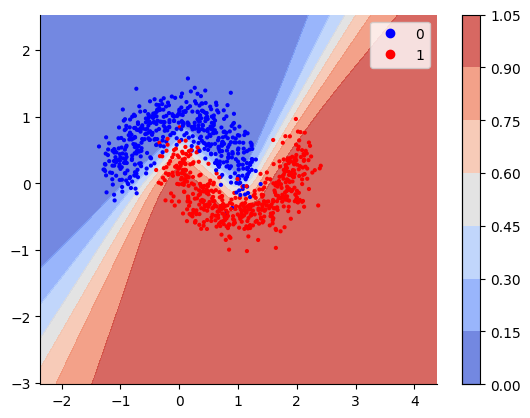

In [21]:
# Predict on test data
bnn.eval()
acc = bnn.predict(X_test, y_test, num_samples=100, device=device)

print(f"The accuracy on the test data is {acc * 100:.2f}%")

# Predict on grid
inputs = np.stack([xx.ravel(), yy.ravel()], axis=-1)
p = bnn.predict(torch.as_tensor(inputs, dtype=torch.get_default_dtype()),
                num_samples=100, device=device)
p = p.reshape(xx.shape)

plot_binary_class(X, Y, xx, yy, p, legend=True, color_bar=True)

### Last-layer BNN with full-rank Gaussian approximation

### MC dropout

MCMC Methods？

## Bayesian CNN - more complex structure